# Clustering

Clustering performed using:

* K-Means
* Gaussian Mixture Model (GMM)


The following implementation works for any number of clusters.

## Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import ncfdtri

## Set random seed

In [2]:
np.random.seed(5)
torch.manual_seed(5)
random.seed(5)

## Arguments regarding data, model and training

In [3]:
N = 512
iters = 10
learning_rate = 0.001
# Number of features
d = 2
# Number of classes
nc = 3
# Minibatch size
bsz = 64
device = torch.device('cuda')

## Generate the Data

In [4]:
def gmm_data(N):
  mu = [[5,5], [0,0], [-4,4]]
  cov = [
      [[4., 3.],
       [3., 2.]],
       [[2.5, 0.],
        [0., 2.5]],
       [[3., -1.5],
         [-1.5, 3.]]
  ]

  def sample_data(sz, nc):
    X = []
    y = []

    for i in range(nc):
      p = np.random.multivariate_normal(mu[i], cov[i], size=sz)
      X.append(p)
      y.append(np.zeros_like(p[:,0]) + i)

    return torch.Tensor(X).view(-1, d), torch.Tensor(y).view(-1)

  X_train, y_train = sample_data(N, nc)
  X_val, y_val = sample_data(N, nc)
  return X_train, y_train, X_val, y_val, nc, d

In [5]:
X_train, y_train, X_val, y_val, nc, d = gmm_data(N)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([1536, 2])
torch.Size([1536])
torch.Size([1536, 2])
torch.Size([1536])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


## Visualize Data

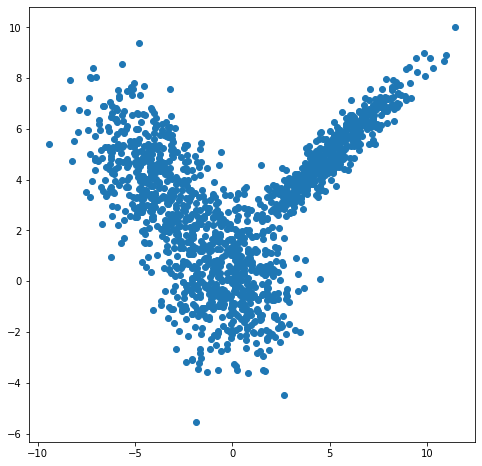

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1])

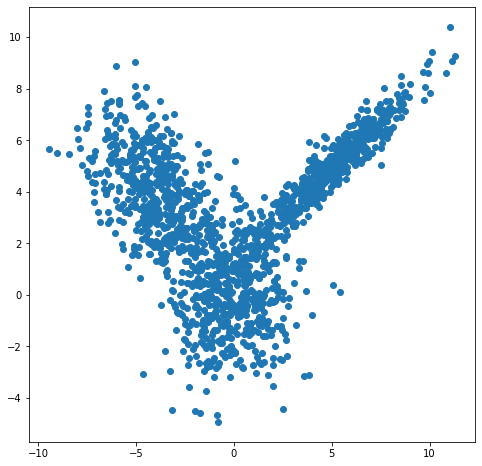

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(X_val[:, 0], X_val[:, 1])

## Plotting function

In [8]:
def plot(X_train, z, means):
  plt.figure(figsize=(8, 8))
  plt.scatter(X_train[:, 0], X_train[:, 1], c=z)
  plt.scatter(means[:,0], means[:,1], marker='*', c='red', s=100)
  plt.show()

# K - Means

In [9]:
class k_means():
  """
  K-Means clustering algorithm
  """
  def __init__(self, nc, X_train):
    """
    Initialise model parameters

    Args:
      nc: int
        Number of classes
      X_train: torch.tensor
        Training data
    
    Returns:
      Nothing
    """
    self.nc = nc
    
    # Initialise the cluster means
    idx = np.arange(X_train.shape[0])
    np.random.shuffle(idx)
    self.means = X_train[idx[:self.nc]]
     
  def train(self, X_train, iters=0):

    """
    Training function

    Args:
      X_train: torch.tensor
        Training data
      iters: int
        Number of training iterations
      Returns:
        loss: float
          training loss of the model
    """

    for i in range(iters):
      
      # Initialize distance tensor
      dist = torch.zeros(X_train.shape[0], nc)
      
      for k in range(nc):
            # Calculate distance of each point from the cluster means
            dist[:, k] = torch.sqrt(torch.sum((X_train - self.means[k])**2,dim=1))
      # Assign point to closest cluster
      z = torch.argmin(dist, dim=1)
      
      loss = 0 # Initialize loss

      for j in range(X_train.shape[0]):
        loss += dist[j, z[j]] / X_train.shape[0] # Calculate loss

      print(f'Iteration: {i} | Loss: {loss:.3f}')  

      for k in range(nc):
        # Calculate cluster means based on the new points
        X_k = X_train[z==k]
        self.means[k] = torch.mean(X_k, axis=0)
    
    return loss

  def eval(self, X):
      """
      Function to gauge model performance
      
      Args:
        X: torch.tensor
          Input matrix
      Returns: 
        z: torch.tensor
          model prediction
      """
      dist = torch.zeros(X.shape[0], nc)
      for k in range(nc):
          dist[:, k] = torch.sqrt(torch.sum((X - self.means[k])**2,dim=1))

      z = torch.argmin(dist, dim=1)

      return z

Iteration: 0 | Loss: 3.229
Iteration: 1 | Loss: 2.195
Iteration: 2 | Loss: 2.006
Iteration: 3 | Loss: 1.949
Iteration: 4 | Loss: 1.937
Iteration: 5 | Loss: 1.935
Iteration: 6 | Loss: 1.935
Iteration: 7 | Loss: 1.935
Iteration: 8 | Loss: 1.935
Iteration: 9 | Loss: 1.935


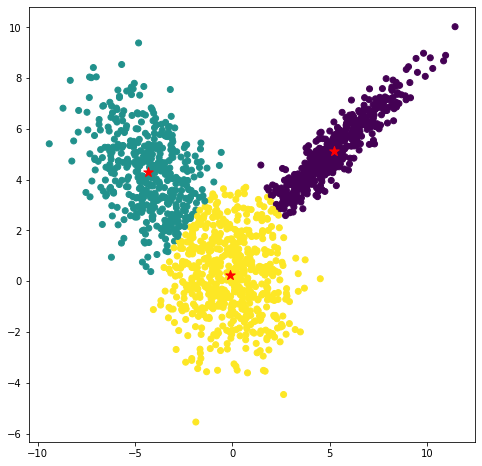

0.40013957023620605


In [10]:
start = time()
# Creating an instance of the model
kmeans = k_means(nc, X_train)
# Training
_ = kmeans.train(X_train, iters)
pred = kmeans.eval(X_train)
plot(X_train, pred, kmeans.means)
print(time() - start)

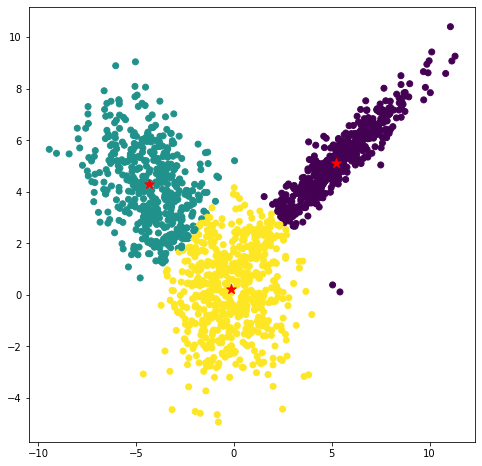

In [11]:
# Performce on unseen data
pred = kmeans.eval(X_val)
plot(X_val, pred, kmeans.means)

# Expectation Maximization (EM) for Gaussian Mixture Model (GMM)

In [12]:
class GMM:
  """
  Gaussian Mixture Model class
  """
  def __init__(self, X_train, nc, d, mean=None):
    """
    Initialize model parameters

    Args:
      X_train: torch.tensor
        data
      nc: Int
        Number of clusters
      d: Int
        Number of features

    Returns:
      Nothing
    """
    self.nc = nc
    self.d = d

    self.prior = torch.ones(self.nc)/ self.nc # Assign equal value to all clusters 1/nc
    
    # Shuffle the data and assign a sample randomly as mean
    if mean is not None:
      self.mean = mean
    else:
      idx = np.arange(X_train.shape[0])
      np.random.shuffle(idx)
      self.mean = X_train[idx[:self.nc]]
    
    self.cov = torch.zeros(self.nc, self.d, self.d)
    for i in range(self.nc):
      self.cov[i] = torch.eye(self.d) # Initialize covariance as identity matrix for each cluster

  def e_step(self, X):
    """
    E-step of the EM algorithm

    Args:
      X: torch.tensor
        data
    Returns:
      z: torch.tensor
        Expectation of each latent variable
    """
    z = torch.zeros(X.shape[0], self.nc) 
    
    for k in range(self.nc):
        z[:, k] = self.prior[k] * multivariate_normal.pdf(X, mean=self.mean[k], cov=self.cov[k])
        
    z /= z.sum(axis=1, keepdims=True)
    
    return z
    
  def m_step(self, X, z):
    """
    M-step of the EM algorithm

    Args:
      X: torch.tensor
        data
      z: torch.tensor
        output of E-step 
    """
    sum_z = torch.sum(z, axis=0)
    
    self.prior = sum_z / X.shape[0] # Compute new priors

    # Recompute means
    self.mean = z.T @ X
    self.mean /= sum_z[:, None] 
    
    # Recompute covariances
    z = z.unsqueeze(2)
    X = X.unsqueeze(1).repeat(1, z.shape[1], 1) - self.mean.unsqueeze(0)
    X = (X * z).unsqueeze(-1) # Shape [N, C, d, 1]
    cov = torch.matmul(X, X.transpose(-2, -1)) # Shape [N, C, d, d]
    self.cov = cov.sum(dim=0) / sum_z[:, None, None]
  
  def train(self, X):
    """
    Training the model

    Args:
      X: torch.tensor
        data
    Returns:
      loss: float
        Training loss
    """
    loss = []
    for i in range(iters):
      z = self.e_step(X)
      self.m_step(X, z)

      cll = torch.zeros(X.shape[0])
      for k in range(nc):
        cll += z[:, k] * torch.log(self.prior[k] * (multivariate_normal.pdf(X, mean=self.mean[k], cov=self.cov[k] + 1e-8)))
      cll = -cll.mean(dim=0)
      loss.append(cll)
 
      print(f'Epoch: {i} train loss: {cll:.2f}')
    
    return loss

  def predict(self, X):
    """
    Compute the expected value of each latent variable based on learned parameters

    Args:
      X: torch.tensor
        data
    Returns:
      Model predictions
    """    
    z = self.e_step(X)

    return torch.argmax(z, dim=1)

Epoch: 0 train loss: 4.49
Epoch: 1 train loss: 4.52
Epoch: 2 train loss: 4.51
Epoch: 3 train loss: 4.51
Epoch: 4 train loss: 4.51
Epoch: 5 train loss: 4.51
Epoch: 6 train loss: 4.51
Epoch: 7 train loss: 4.51
Epoch: 8 train loss: 4.51
Epoch: 9 train loss: 4.51


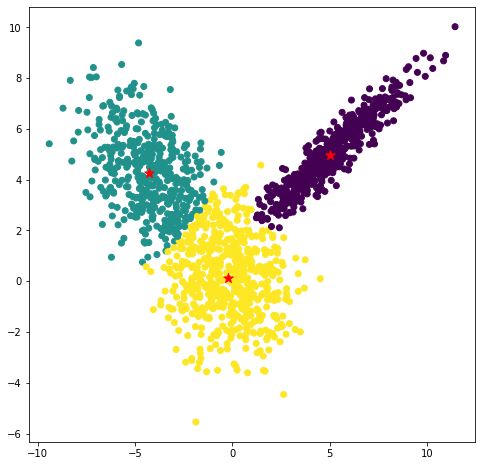

In [13]:
# Create an instance
gmm = GMM(X_train, nc, d, kmeans.means)
# Training
loss = gmm.train(X_train)
# Prediction
pred = gmm.predict(X_train)
plot(X_train, pred, gmm.mean)

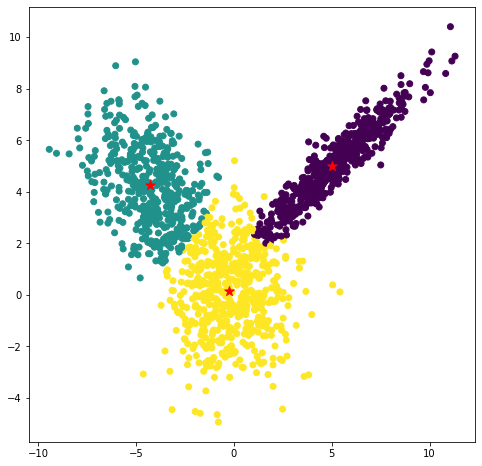

In [14]:
pred = gmm.predict(X_val)
plot(X_val, pred, gmm.mean)

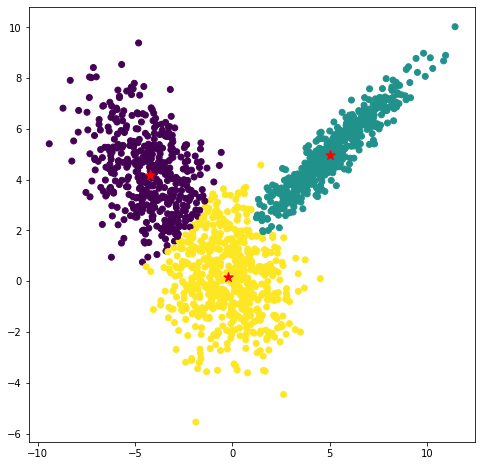

In [15]:
# @title GMM using sklearn

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = nc).fit(X_train)
z = gm.predict(X_train)
plot(X_train, z, gm.means_)